# Business Case
As a 3rd party independent contractor, we have been asked by various companies such as Apple and Google to determine how they can increase customer satisfaction by first identifying the  features that customers are most unhappy with and then finding creative solutions to enhance these features. One of our methods of accomplishing this is to mine a database  of tweets with manually encoded sentiments for each corresponding tweet. In so doing we can easily determine which products/services customers feel negatively towards. With that information, they have asked us to hand them the code that will help them predict the emotion towards a tweets so they can systematically  organize future tweets without manually inputting sentiments. Ultimately  our job is to create a model which can predict future tweet sentiment so they can decide which areas need improvement in order to enhance their customers experience.

# The Data

The dataset used in this project is available on data.world <a href="https://data.world/crowdflower/brands-and-product-emotions">here</a>. It is called *Brands and Product Emotions* and it contains a little over 9000 rows of tweets. Each tweet has a manually encoded emotion paired with it (positive, negative, or no emotion). 

# Project Outline
* [Import Modules and Dataset](#import)
* [Basic Data Inspection](#inspect)
* [Preprocess data](#preprocess)
 * [Tokenization](#tokenization)
 * [Lemmatization](#lemmatization)
 * [Filtering stop words](#stop_words)
 * [Vectorization](#vectorize)
     * Count Vectorizor
     * TFIDF Vectorizor
     * Word Embeddings
* [EDA](#eda)
* [Modeling](#model)
* [Conclusion](#conclusion)

# <a id='import'>Import</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
# nltk.download('stopwords')
from nltk.stem import SnowballStemmer
import re

import spacy
# Load model to return language object
nlp = spacy.load('en_core_web_sm')

from wordcloud import WordCloud

In [2]:
df = pd.read_csv('tweet_sentiment.csv',encoding='latin1')

# <a id='inspect'>Inspect</a>

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
len(df)

9093

In [5]:
print(df['tweet_text'][0])

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


In [6]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
df['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

NaN                                5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [8]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [9]:
df = df[df.is_there_an_emotion_directed_at_a_brand_or_product != 'I can\'t tell']
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [10]:
df['tweet_text'][6]

nan

In [11]:
df.dropna(subset=['tweet_text'], inplace=True)

In [12]:
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [13]:
df.rename(columns={"emotion_in_tweet_is_directed_at": "emotion_directed_at", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [14]:
df.head()

,tweet_text,emotion_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# <a id='preprocess'>Baseline model 1</a>
 > No brand column, included neutral tweets

In [15]:
# For now, just going to use tweet text and emtotion column

X = df['tweet_text']
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [16]:
text_clf = Pipeline([('Tfidf', TfidfVectorizer()),
                    ('clf', RandomForestClassifier())])

In [17]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('Tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [18]:
predictions = text_clf.predict(X_test)

In [19]:
print(confusion_matrix(y_test, predictions))

[[  27  138   24]
 [  14 1447  151]
 [   1  560  319]]


In [20]:
print(classification_report(y_test,predictions))

                                    precision    recall  f1-score   support

                  Negative emotion       0.64      0.14      0.23       189
No emotion toward brand or product       0.67      0.90      0.77      1612
                  Positive emotion       0.65      0.36      0.46       880

                          accuracy                           0.67      2681
                         macro avg       0.65      0.47      0.49      2681
                      weighted avg       0.66      0.67      0.63      2681



In [21]:
print(accuracy_score(y_test, predictions))

0.6687803058560239


# Baseline model 2
> Took away neutral tweets, still no brand column

In [22]:
new_df = df[df.emotion != 'No emotion toward brand or product']
new_df['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [23]:
X = new_df['tweet_text']
y = new_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [24]:

text_clf = Pipeline([('Tfidf', TfidfVectorizer()),
                    ('clf', RandomForestClassifier())])

In [25]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('Tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [26]:
predictions = text_clf.predict(X_test)

In [27]:
print(classification_report(y_test,predictions))

                  precision    recall  f1-score   support

Negative emotion       0.90      0.21      0.35       173
Positive emotion       0.87      1.00      0.93       892

        accuracy                           0.87      1065
       macro avg       0.88      0.60      0.64      1065
    weighted avg       0.87      0.87      0.83      1065



In [28]:
print(confusion_matrix(y_test, predictions))

[[ 37 136]
 [  4 888]]


In [29]:
print(accuracy_score(y_test, predictions))

0.8685446009389671


In [30]:
X_test

685     New Post: iPad 2 Launches to Huge Lines at App...
6393    RT @mention NYT app for iPad: not &quot;here's...
7851    Steve Jobs doesn't position the iPhone as a de...
5813    RT @mention Google Circles will be toast if it...
2944    Thanks @mention for giving me new top cover fo...
                              ...                        
6708    RT @mention Temp Apple Store 6th St  Austin #s...
3491    I threw this together to keep on my iPad to at...
4717    &quot;I know I'm right, I own an Apple&quot; #...
3121    #sxsw is exposing my iphone's horrendous batte...
5757    RT @mention Funny moment at #sxsw panel when D...
Name: tweet_text, Length: 1065, dtype: object

In [31]:
text_clf.predict(['The iphone is the best product ever'])

array(['Positive emotion'], dtype=object)

In [32]:
feature_importance = list(zip(text_clf.named_steps['Tfidf'].get_feature_names(), text_clf.named_steps['clf'].feature_importances_))
feature_importance.sort(key=lambda x:x[1], reverse=True)

In [33]:
feature_importance

[('sxsw', 0.014029892714025747),
 ('link', 0.013454170802781313),
 ('headaches', 0.009125060611967228),
 ('mention', 0.008832592388038839),
 ('not', 0.008349216761658203),
 ('hate', 0.007046836935779142),
 ('the', 0.005871816354935959),
 ('iphone', 0.005678613267087887),
 ('ipad', 0.005605111687491154),
 ('at', 0.005493803172059202),
 ('is', 0.00549167533589493),
 ('money', 0.005127466091494702),
 ('design', 0.005085498130953869),
 ('fascist', 0.004894668488202584),
 ('america', 0.004875597579621531),
 ('apple', 0.0047780241676556885),
 ('fail', 0.004570078842548508),
 ('for', 0.004545486402570788),
 ('fades', 0.004419222729090945),
 ('why', 0.004418543896659724),
 ('needs', 0.004318332373401584),
 ('to', 0.004193802641845833),
 ('rt', 0.004190250852852387),
 ('instead', 0.004124358272028804),
 ('doesn', 0.004084977453775677),
 ('battery', 0.004056119326206261),
 ('will', 0.003849843580079966),
 ('quot', 0.0037728574077511012),
 ('of', 0.003687288880375214),
 ('like', 0.003628760131677

> The first 2 baseline model's were a Random Forest Classifier and did not include tokenization or Lemitization. The first model which included the neutral tweets had an overall accuracy of around 65% while the second model, which did not take into account the neutral tweets had a higher accuracy score of approximately 85%. 
> Another point to note is the feature importance for the second model. Certain words were deemed important although in fact they have no importance at all. Some of these words include: not, is, as ,at, iPad, and more. Most of these words will probably be taken out when removing stop words.
> After having tried out 2 different models without much preprocessing, we will now go on to show how tokenization and lemitization can help us with our predictions

## <a id='tokenization'>Tokenization</a>

In [34]:
# Creating 'doc' col which will store all of our tweet_texts as docs
df['doc'] = [nlp(text) for text in df.tweet_text]
df.sample(3)

,tweet_text,emotion_directed_at,emotion,doc
7905,So where's the apple store in Austin for #SXSW?,NaN,No emotion toward brand or product,"(So, where, 's, the, apple, store, in, Austin,..."
1213,On my way to #sxsw Has anyone seen any lines i...,NaN,No emotion toward brand or product,"(On, my, way, to, #, sxsw, Has, anyone, seen, ..."
3764,our @mention AMI sampler is live on #iTunes! J...,NaN,No emotion toward brand or product,"(our, @mention, AMI, sampler, is, live, on, #,..."


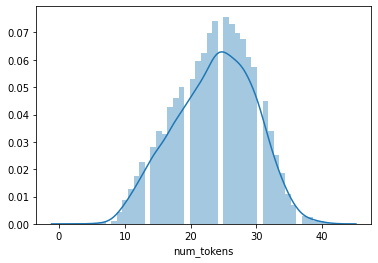

In [35]:
# Sum the number of tokens in each Doc
df['num_tokens'] = [len(token) for token in df.doc]
# Visualize histogram of tokens per tweet
g = sns.distplot(df.num_tokens)

## <a id='lemmatization'>Lemmatization</a>

> Future work

## <a id='stop_words'>Filtering stop words/ stemming</a>

In [51]:
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [71]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['iPad','Apple', 'Google', 'sxsw', 'SXSW', 'mention', 'iPhone', 'iPad2', 'ipad', 'iphone', '3g', 'austin', 'festival', 'google', 'apple']
stopwords.extend(newStopWords)

In [72]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [73]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: preprocess(x))

In [74]:
df.head()

,tweet_text,emotion_directed_at,emotion,doc,num_tokens
0,wesley83 3 hrs tweeting rise dead need upgrade...,iPhone,Negative emotion,"(.@wesley83, I, have, a, 3, G, iPhone, ., Afte...",32
1,know fludapp awesome app likely appreciate des...,iPad or iPhone App,Positive emotion,"(@jessedee, Know, about, @fludapp, ?, Awesome,...",29
2,wait 2 also sale,iPad,Positive emotion,"(@swonderlin, Can, not, wait, for, #, iPad, 2,...",19
3,hope year crashy year app,iPad or iPhone App,Negative emotion,"(@sxsw, I, hope, this, year, 's, festival, is,...",20
4,great stuff fri marissa mayer tim reilly tech ...,Google,Positive emotion,"(@sxtxstate, great, stuff, on, Fri, #, SXSW, :...",30


## <a id='vectorize'>Vectorizing - words to numbers</a>


### Count Vectorizer

In [75]:
X = df['tweet_text']
y = df['emotion']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Using count vecorization to feed into model
count_vectorizer = CountVectorizer()
X_count_train = count_vectorizer.fit_transform(X_train)
X_count_test = count_vectorizer.transform(X_test)

In [76]:
# Random forest classifier
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_count_train, y_train)

train_preds = random_forest_clf.predict(X_count_train)
test_preds = random_forest_clf.predict(X_count_test)

print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")

print(confusion_matrix(y_test, test_preds))

Train Accuracy: 0.9916442852879738
Test Accuracy: 0.6808415398388541
[[  26  115   18]
 [  10 1184  162]
 [   3  405  311]]


### TFIDF Vectorizer

In [77]:
X = df['tweet_text']
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Tfidf_vectorizer = TfidfVectorizer()

X_count_train = Tfidf_vectorizer.fit_transform(X_train)
X_count_test = Tfidf_vectorizer.transform(X_test)

In [78]:
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_count_train, y_train)

train_preds = random_forest_clf.predict(X_count_train)
test_preds = random_forest_clf.predict(X_count_test)

print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")

print(confusion_matrix(y_test, test_preds))

Train Accuracy: 0.9916442852879738
Test Accuracy: 0.6794986571172784
[[  27  105   27]
 [  11 1179  166]
 [   4  403  312]]


In [88]:
print(classification_report(y_test,test_preds))

                                    precision    recall  f1-score   support

                  Negative emotion       0.64      0.17      0.27       159
No emotion toward brand or product       0.70      0.87      0.77      1356
                  Positive emotion       0.62      0.43      0.51       719

                          accuracy                           0.68      2234
                         macro avg       0.65      0.49      0.52      2234
                      weighted avg       0.67      0.68      0.65      2234



In [ ]:
# Feature importance
# Explain models at each spot
# Tune random forest and see if overfitting problem
# Try cleaning out words that have low tfidf scores
# Try getting emotion column out
# Class imbalance
# Add overlap of positive and negative to stop words

### Word Embeddings - future work

# <a id='eda'>EDA</a>
* Word cloud (for presentation) - neg, pos, neutral
* Most common words in pos, neg, neutral
* Top highest highest tfidf score (pos, neg, neutral)
* Any other curious distributions in data

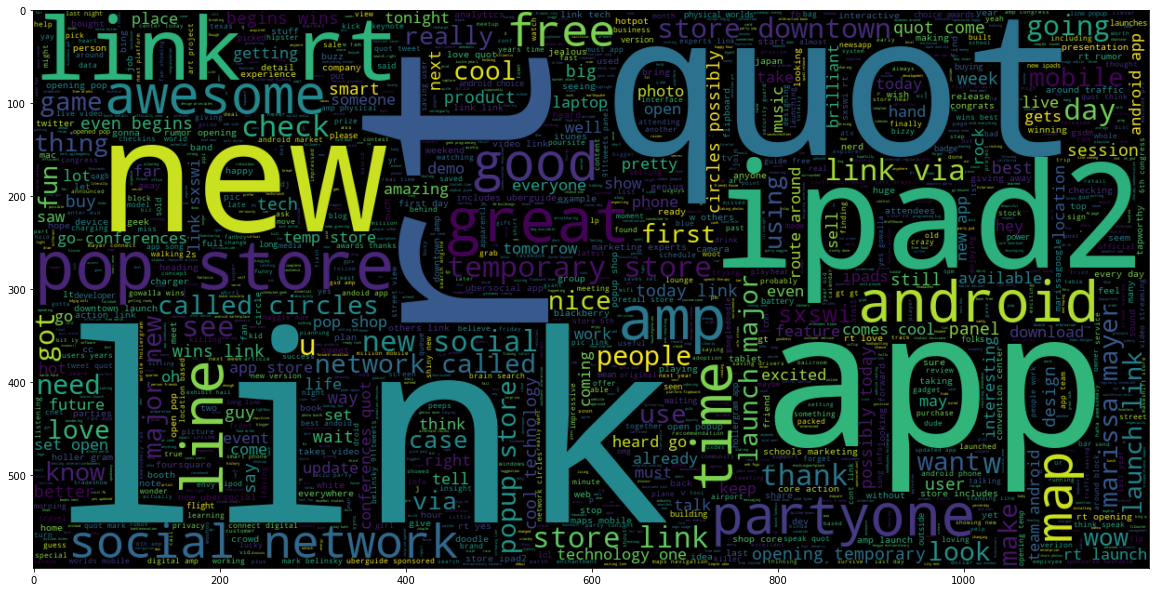

In [85]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1200 , height = 600).generate(" ".join(df[df.emotion == 'Positive emotion'].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

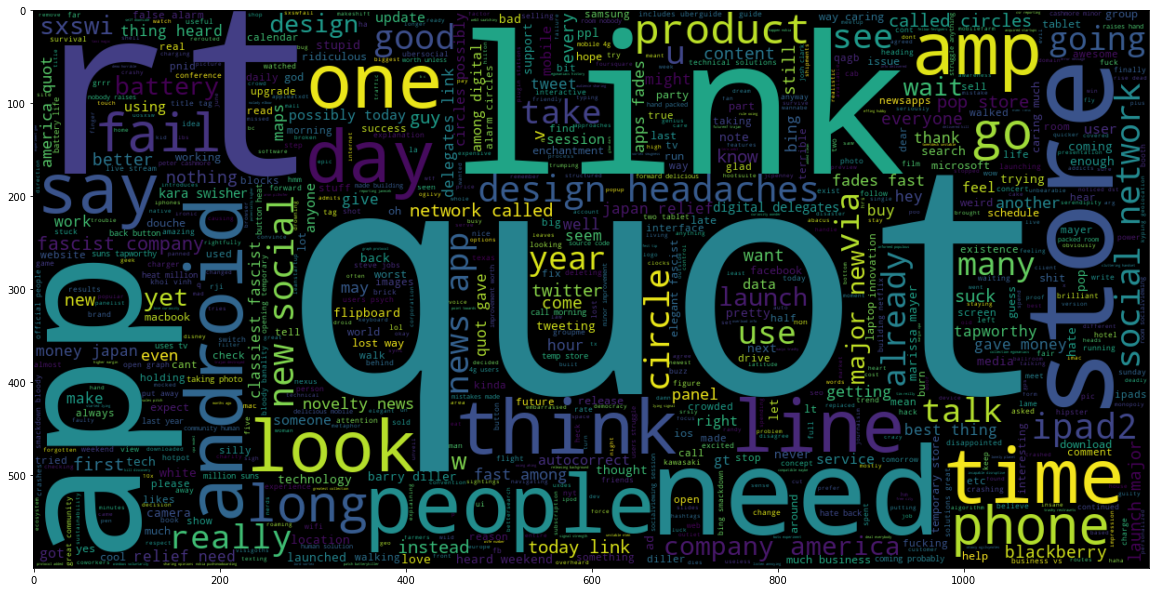

In [87]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1200 , height = 600).generate(" ".join(df[df.emotion == 'Negative emotion'].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

# <a id='model'>Model</a>

* Naive bayes good for test
* Tree forest type to get feature importances
* Multi-class project - include neutral
> Modeling done above

## LDA - second nlp notebook (level up)

# <a id='conclusion'>Conclusion</a>

What we have seen thus far is as follows:
* Vanilla Model with neutral emotion: 0.67 accuracy score
* Vanilla Model including just pos and neg emotions: 0.87 accuracy score
* Random forest model with preprocessing (count vectorizer): 0.68 accuracy 
* Random forest model with preprocessing (Tfidf vectorizer): 0.679 accuracy

Insights:
* Seems not to have made much of a difference which vectorizer used. 
* Future work will be to get to the bottom of why scores didn't change for the most part
* Preprocessing doesn't seem to have made much of a difference either
* 

Future work:
* Try some different models out
* Figure out how to balance distribution in NLP project
* Next step is to organize tweets by product and make business recommendations based on that